In [ ]:

import skimage
import os
import sys
import json
import numpy as np
from numpy import zeros
from numpy import asarray
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from matplotlib import pyplot
import random
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import datetime
from PIL import Image
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Minor/Mask_RCNN/")
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
 # To find local version of the library
from mrcnn_v2.config import Config
"""from mrcnn import model as modellib, utils
from mrcnn.utils import Dataset
from mrcnn.model import log
from mrcnn import visualize"""
from mrcnn_v2 import utils
from mrcnn_v2 import visualize
from mrcnn_v2.visualize import display_images
from mrcnn_v2 import model as modellib
from mrcnn_v2.model import log
from mrcnn_v2.model import mold_image
from numpy import expand_dims
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


############################################################
#  Configurations
############################################################


class GanConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "gan"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

class InferConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "gan"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    GPU_COUNT=1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.3

############################################################
#  Dataset
############################################################

class GanDataset(utils.Dataset):
    annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/deepfashionfcoco.json')))
    def load_dataset(self, dataset_dir,is_train):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("gan", 1, "short_sleeved_shirt")
        self.add_class("gan", 2, "long_sleeved_shirt")
        self.add_class("gan", 3, "short_sleeved_outwear")
        self.add_class("gan", 4, "long_sleeved_outwear")
        self.add_class("gan", 5, "vest")
        self.add_class("gan", 6, "sling")
        self.add_class("gan", 7, "shorts")
        self.add_class("gan", 8, "trousers")
        self.add_class("gan", 9, "skirt")
        self.add_class("gan", 10, "short_sleeved_dress")
        self.add_class("gan", 11, "long_sleeved_dress")
        self.add_class("gan", 12, "vest_dress")
        self.add_class("gan", 13, "sling_dress")
        
        images_dir = dataset_dir + 'final_train/'
        annotations_dir = dataset_dir + 'final_annos/'
 
            
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        ann= annotations['annotations']
        dire=sorted(os.listdir(images_dir))

        for filename in dire:       
            # extract image i
            image_id = int(filename[:6])
            
            if is_train and image_id>=7000:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and (image_id<7000):
                
                continue         
            # setting image file
            img_path = images_dir + str(image_id).zfill(6) + ".jpg"
            # setting annotations file
            ann_path = annotations_dir + str(image_id).zfill(6) + '.json'    
            # adding images and annotations to dataset
            self.add_image('gan', image_id=image_id, path=img_path, annotation=ann_path)
    
    
    def extract_boxes(self, filename):
        fileid=int(filename[36:-5])
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        df=pd.DataFrame.from_dict(annotations['annotations'])
        anno=df.groupby('image_id')
        boxes=list(anno.get_group(fileid)['bbox'])
        
        #width=annotations['images'][fileid]['width']
        #height=annotations['images'][fileid]['height']
        return boxes #, width, height
    
    def load_mask(self, image_id):
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        info = self.image_info[image_id]
        path = info['annotation']
        boxes= self.extract_boxes(path)
        h=annotations['images'][image_id]['height']
        w=annotations['images'][image_id]['width']
        masks = zeros([h, w,len(boxes)], dtype='uint8')
        
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        for i in range(len(boxes)):
            box=boxes[i]
            row_s, row_e = box[1], box[1]+box[3]
            col_s, col_e = box[0], box[0]+box[2]
            masks[row_s:row_e, col_s:col_e,i] = 1
        df=pd.DataFrame.from_dict(annotations['annotations'])
        anno=df.groupby('image_id')
      #  class_ids=list()
        class_ids=list(anno.get_group(info['id'])['category_id'])
        return masks,asarray(class_ids,dtype='int32')
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']  
############################################################
#  Training
############################################################
def train(model):
  train_set = GanDataset()
  train_set.load_dataset('/content/drive/My Drive/Minor/',is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  val_set = GanDataset()
  val_set.load_dataset('/content/drive/My Drive/Minor/',is_train=False)
  val_set.prepare()
  print('Train: %d' % len(val_set.image_ids))
  print("Training network heads")
  model.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        
        # Read image
        image = skimage.io.imread(image_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def test(model):

  train_set = GanDataset()
  train_set.load_dataset('/content/drive/My Drive/Minor/',is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  val_set = GanDataset()
  val_set.load_dataset('/content/drive/My Drive/Minor/',is_train=False)
  val_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  train_mAP = evaluate_model(train_set, model, cfg)
  print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
  test_mAP = evaluate_model(test_set, model, cfg)
  print("Test mAP: %.3f" % test_mAP)
  """image_id =1
  #image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(train_set, config, image_id, use_mini_mask=False)
  image = skimage.io.imread('/content/drive/My Drive/gan_train/000001.jpg')
  results = model.detect([image], verbose=1)
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            train_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
  #print(r['rois']);
  #image=visualize.draw_box(image,gt_bbox[0],[0,0,0])
  #cv2_imshow(image)
  for i in r['rois']:
    crop_img=image[i[0]:i[2],i[1]:i[3]]
    cv2_imshow(crop_img)
    cv2.imwrite("/content/drive/My Drive/results/crop"+str(i[0])+".jpg",crop_img)
    """
 # log("gt_class_id", gt_class_id)
  #log("gt_bbox", gt_bbox)
  #log("gt_mask", gt_mask)


if __name__ == '__main__':
  x=input("train or test\n")
  if(x=='train'):
    config=GanConfig()
    model = modellib.MaskRCNN(mode='training', model_dir='/weights', config=config)
    model.load_weights('/content/drive/My Drive/Minor/mask_rcnn_gan_0008.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    train(model)
  else:
    config=InferConfig()
    model = modellib.MaskRCNN(mode='inference', model_dir='/weights', config=config)
    model.load_weights('/content/drive/My Drive/Minor/mask_rcnn_gan_0008.h5', by_name=True)
    test(model)
    #detect_and_color_splash(model, video_path='/content/video.mp4')

In [ ]:
!pip install q tensorflow==2.1.0

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [ ]:
!tf_upgrade_v2 \
--intree /content/drive/My\ Drive/Minor/Mask_RCNN/mrcnn/  \
--outtree /content/drive/My\ Drive/Minor/Mask_RCNN/mrcnn/ \


TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 6 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



1.15.2
train or test
test
Train: 6999
Processing 1 images
image                    shape: (960, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


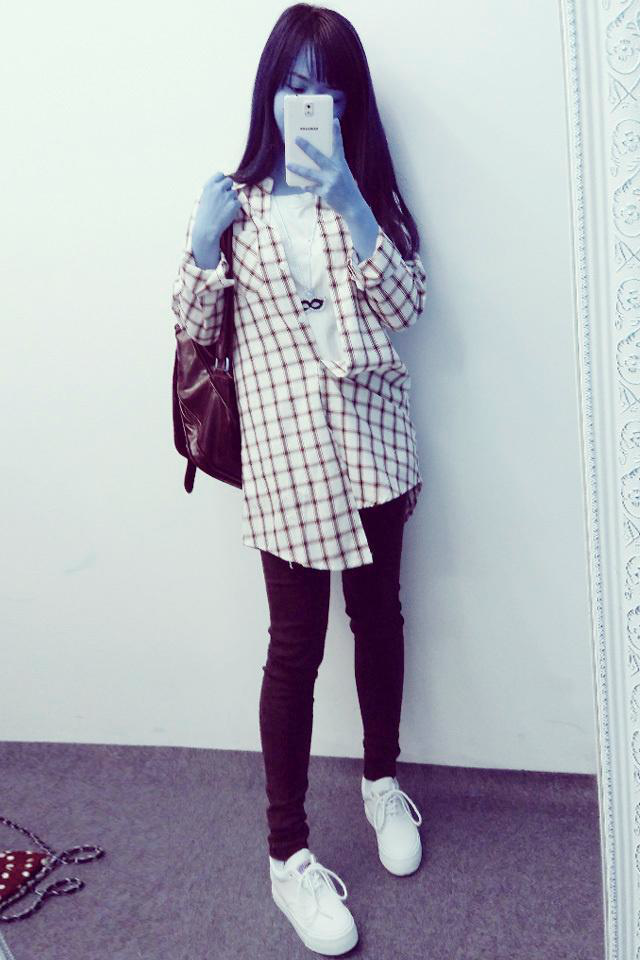

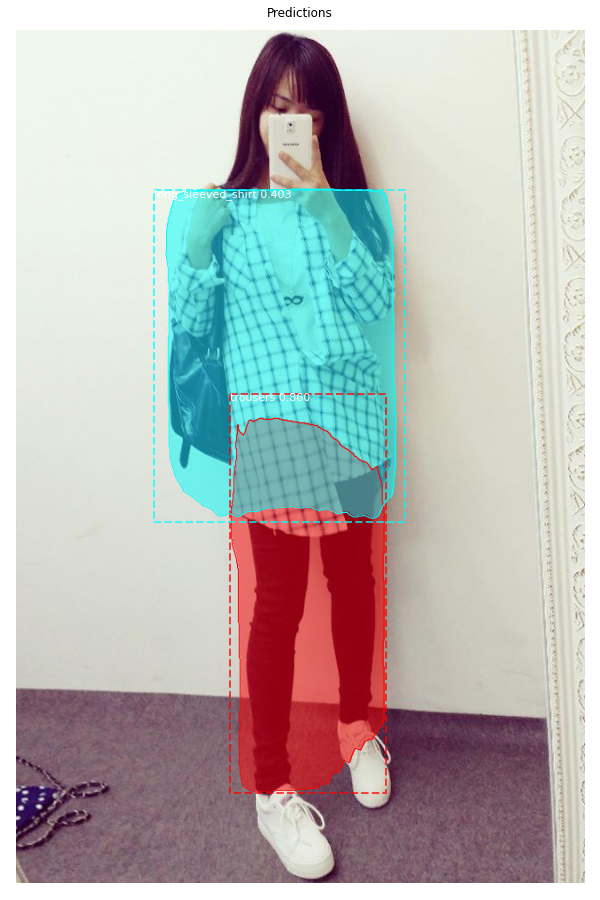

In [ ]:
import skimage
import os
import sys
import json
import numpy as np
from numpy import zeros
from numpy import asarray
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from matplotlib import pyplot
import random
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import datetime
from PIL import Image
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Minor/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
 # To find local version of the library
from mrcnn.config import Config
"""from mrcnn import model as modellib, utils
from mrcnn.utils import Dataset
from mrcnn.model import log
from mrcnn import visualize"""
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.model import mold_image
from numpy import expand_dims
from mrcnn.utils import compute_ap
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


############################################################
#  Configurations
############################################################


class GanConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "gan"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

class InferConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "gan"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    GPU_COUNT=1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.3

############################################################
#  Dataset
############################################################

class GanDataset(utils.Dataset):
    annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/deepfashionfcoco.json')))
    def load_dataset(self, dataset_dir,is_train):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("gan", 1, "short_sleeved_shirt")
        self.add_class("gan", 2, "long_sleeved_shirt")
        self.add_class("gan", 3, "short_sleeved_outwear")
        self.add_class("gan", 4, "long_sleeved_outwear")
        self.add_class("gan", 5, "vest")
        self.add_class("gan", 6, "sling")
        self.add_class("gan", 7, "shorts")
        self.add_class("gan", 8, "trousers")
        self.add_class("gan", 9, "skirt")
        self.add_class("gan", 10, "short_sleeved_dress")
        self.add_class("gan", 11, "long_sleeved_dress")
        self.add_class("gan", 12, "vest_dress")
        self.add_class("gan", 13, "sling_dress")
        
        images_dir = dataset_dir + 'final_train/'
        annotations_dir = dataset_dir + 'final_annos/'
 
            
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        ann= annotations['annotations']
        dire=sorted(os.listdir(images_dir))

        for filename in dire:       
            # extract image i
            image_id = int(filename[:6])
            
            if is_train and image_id>=7000:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and (image_id<7000):
                continue
                
            # setting image file
            img_path = images_dir + str(image_id).zfill(6) + ".jpg"
            # setting annotations file
            ann_path = annotations_dir + str(image_id).zfill(6) + '.json'
            
            # adding images and annotations to dataset
            self.add_image('gan', image_id=image_id, path=img_path, annotation=ann_path)
        
    def extract_boxes(self, filename):
        fileid=int(filename[36:-5])
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        df=pd.DataFrame.from_dict(annotations['annotations'])
        anno=df.groupby('image_id')
        boxes=list(anno.get_group(fileid)['bbox'])
        
        #width=annotations['images'][fileid]['width']
        #height=annotations['images'][fileid]['height']
        return boxes #, width, height
    
    def load_mask(self, image_id):
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        info = self.image_info[image_id]
        path = info['annotation']
        boxes= self.extract_boxes(path)
        h=annotations['images'][image_id]['height']
        w=annotations['images'][image_id]['width']
        masks = zeros([h, w,len(boxes)], dtype='uint8')
        
        annotations = json.load(open(os.path.join('/content/drive/My Drive/Minor/','deepfashionfcoco.json')))
        for i in range(len(boxes)):
            box=boxes[i]
            row_s, row_e = box[1], box[1]+box[3]
            col_s, col_e = box[0], box[0]+box[2]
            masks[row_s:row_e, col_s:col_e,i] = 1
        df=pd.DataFrame.from_dict(annotations['annotations'])
        anno=df.groupby('image_id')
      #  class_ids=list()
        class_ids=list(anno.get_group(info['id'])['category_id'])
        return masks,asarray(class_ids,dtype='int32')
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']  
############################################################
#  Training
############################################################
def train(model):
  train_set = GanDataset()
  train_set.load_dataset('/content/drive/My Drive/Minor/',is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  val_set = GanDataset()
  val_set.load_dataset('/content/drive/My Drive/Minor/',is_train=False)
  val_set.prepare()
  print('Train: %d' % len(val_set.image_ids))
  print("Training network heads")
  model.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads') #head,3+,4+,all

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        
        # Read image
        image = skimage.io.imread(image_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
def test(model):
  """
  train_set = GanDataset()
  train_set.load_dataset('/content/drive/My Drive/',is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  val_set = GanDataset()
  val_set.load_dataset('/content/drive/My Drive/',is_train=False)
  val_set.prepare()
  print('Train: %d' % len(val_set.image_ids))
  train_mAP = evaluate_model(train_set, model, config)
  print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
  test_mAP = evaluate_model(test_set, model, config)
  print("Test mAP: %.3f" % test_mAP)
  """
  train_set = GanDataset()
  train_set.load_dataset('/content/drive/My Drive/Minor/',is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))
  #image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(train_set, config, image_id, use_mini_mask=False)
  
  #for path in os.listdir("/content/drive/My Drive/test/"):
#002114
  image = skimage.io.imread('/content/drive/My Drive/Minor/final_train/'+'002114.jpg')
  results = model.detect([image], verbose=1)
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], train_set.class_names, r['scores'], ax=ax,title="Predictions")
 #print(r['rois']);region of interest
  #image=visualize.draw_box(image,gt_bbox[0],[0,0,0])
  cv2_imshow(image)
  """
    for i in r['rois']:
      crop_img=image[i[0]:i[2],i[1]:i[3]]
      crop_img=cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
      cv2_imshow(crop_img)
      cv2.imwrite("/content/drive/My Drive/results/crop"+str(i[0])+".jpg",crop_img)
   """ 
  #log("gt_class_id", gt_class_id)
  #log("gt_bbox", gt_bbox)
  #log("gt_mask", gt_mask)

if __name__ == '__main__':
  import tensorflow
  print(tensorflow.__version__)
  x=input("train or test\n")
  if(x=='train'):
    config=GanConfig()
    model = modellib.MaskRCNN(mode='training', model_dir='/weights', config=config)
    model.load_weights('/content/drive/My Drive/Minor/mask_rcnn_gan_0008.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    train(model)
  else:
    config=InferConfig()
    model = modellib.MaskRCNN(mode='inference', model_dir='/weights', config=config)
    model.load_weights('/content/drive/My Drive/Minor/mask_rcnn_gan_0010.h5', by_name=True)
    test(model)
    #detect_and_color_splash(model, video_path='/content/drive/My Drive/Minor/video5.mp4')

In [ ]:
!pip install keras==2.0.8

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
!pip install tensorflow-gpu==1.15.2

In [ ]:
!tensorboard --logdir /weights/gan20200513T0337/ --host localhost --port 8088

TensorBoard 1.15.0 at http://localhost:8088/ (Press CTRL+C to quit)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
